# 2a_fasterrcnn_Liam.ipynb

## Faster R-CNN Object Detection for Maltese Traffic Signs

**Student:** Liam  
**Architecture:** Faster R-CNN (ResNet50-FPN backbone)  
**Task:** Detect and classify traffic signs (6 classes)  

### Classes:
1. Stop
2. No_Entry
3. Pedestrian_Crossing
4. Roundabout_Ahead
5. No_Through_Road
6. Blind_Spot_Mirror

## 1. Setup & Imports

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using device: cuda


In [ ]:
# Install required packages
!pip install pycocotools -q

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from collections import defaultdict
import random
import time
from tqdm import tqdm

import torch
import torch.utils.data
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

print("All imports successful!")

All imports successful!


In [ ]:
# Dataset paths - UPDATE IF NEEDED
BASE_PATH = "/content/drive/MyDrive/ARI3129_CV_Project"
IMAGES_DIR = os.path.join(BASE_PATH, "images")
ANNOTATIONS_FILE = os.path.join(BASE_PATH, "mtsd_with_prefixes.json")


# Verify paths exist
assert os.path.exists(IMAGES_DIR), f"Images directory not found: {IMAGES_DIR}"
assert os.path.exists(ANNOTATIONS_FILE), f"Annotations file not found: {ANNOTATIONS_FILE}"

print(f"Images directory: {IMAGES_DIR}")
print(f"Annotations file: {ANNOTATIONS_FILE}")
print(f"Number of images: {len(os.listdir(IMAGES_DIR))}")

Images directory: /content/drive/MyDrive/ARI3129_CV_Project/images
Annotations file: /content/drive/MyDrive/ARI3129_CV_Project/mtsd_with_prefixes.json
Number of images: 484


## 2. Load and Explore Dataset

In [ ]:
# Load COCO annotations
with open(ANNOTATIONS_FILE, 'r') as f:
    coco_data = json.load(f)

print(f"Total images in annotations: {len(coco_data['images'])}")
print(f"Total annotations: {len(coco_data['annotations'])}")
print(f"\nCategories:")
for cat in coco_data['categories']:
    print(f"  {cat['id']}: {cat['name']}")

Total images in annotations: 484
Total annotations: 496

Categories:
  0: Stop
  1: No_Entry
  2: Pedestrian_Crossing
  3: Roundabout_Ahead
  4: No_Through_Road
  5: Blind_Spot_Mirror


Class Distribution:
  No_Entry: 184
  Stop: 124
  Pedestrian_Crossing: 99
  Roundabout_Ahead: 37
  No_Through_Road: 31
  Blind_Spot_Mirror: 21


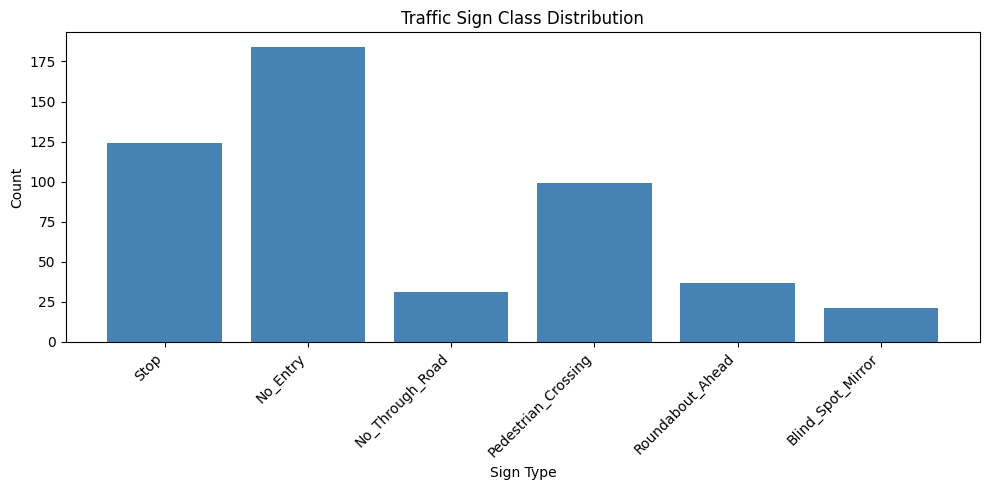

In [ ]:
# Class distribution
cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
class_counts = defaultdict(int)

for ann in coco_data['annotations']:
    class_counts[cat_id_to_name[ann['category_id']]] += 1

print("Class Distribution:")
for cls, count in sorted(class_counts.items(), key=lambda x: -x[1]):
    print(f"  {cls}: {count}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
plt.xlabel('Sign Type')
plt.ylabel('Count')
plt.title('Traffic Sign Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Dataset Class

In [ ]:
class TrafficSignDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, coco_data, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms

        # Build mappings
        self.images = coco_data['images']
        self.img_id_to_info = {img['id']: img for img in self.images}

        # Group annotations by image
        self.img_to_anns = defaultdict(list)
        for ann in coco_data['annotations']:
            self.img_to_anns[ann['image_id']].append(ann)

        # Filter to only images that exist on disk
        self.valid_images = []
        for img in self.images:
            img_path = os.path.join(images_dir, img['file_name'])
            if os.path.exists(img_path):
                self.valid_images.append(img)

        print(f"Found {len(self.valid_images)}/{len(self.images)} valid images")

        # Category mapping (COCO uses 0-indexed, Faster R-CNN expects 1-indexed with 0 as background)
        self.cat_mapping = {cat['id']: idx + 1 for idx, cat in enumerate(coco_data['categories'])}
        self.num_classes = len(coco_data['categories']) + 1  # +1 for background

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Get annotations for this image
        anns = self.img_to_anns[img_info['id']]

        boxes = []
        labels = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            # Convert to [x1, y1, x2, y2] format
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_mapping[ann['category_id']])
            areas.append(ann.get('area', w * h))

        # Handle images with no annotations
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_info['id']]),
            'area': areas,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

print("Dataset class defined!")

Dataset class defined!


In [ ]:
# Data transforms
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

print("Transforms defined!")

Transforms defined!


## 4. Train/Val/Test Split

In [ ]:
# Check what filenames are in the JSON vs what's in the folder
import os

# List actual files in images folder
actual_files = os.listdir(IMAGES_DIR)
print(f"Files in images folder: {len(actual_files)}")
print(f"First 5 actual files: {actual_files[:5]}")

# List filenames from JSON
json_files = [img['file_name'] for img in coco_data['images'][:5]]
print(f"\nFirst 5 files from JSON: {json_files}")

Files in images folder: 484
First 5 actual files: ['676d51a5-IMG_0022.jpg', '4ace6e26-IMG_0031.jpg', 'f23f72e4-IMG_0029.jpg', 'eb27b15a-IMG_0025.jpg', 'd5d53142-IMG_0034.jpg']

First 5 files from JSON: ['4cb9f83b-IMG_6118.JPG', 'bef019e2-IMG_6124.JPG', '3df3fe3b-IMG_6252.JPG', 'd33c21c3-IMG_6246.JPG', '37c705bd-IMG_6247.JPG']


In [ ]:
from sklearn.model_selection import train_test_split

# Create full dataset first to get valid images
full_dataset = TrafficSignDataset(IMAGES_DIR, coco_data, transforms=None)

# Split indices
indices = list(range(len(full_dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

print(f"Train set: {len(train_idx)} images")
print(f"Val set: {len(val_idx)} images")
print(f"Test set: {len(test_idx)} images")

Found 484/484 valid images
Train set: 338 images
Val set: 73 images
Test set: 73 images


In [ ]:
# Create separate COCO data dicts for each split
def create_split_coco(valid_images, indices, coco_data):
    split_images = [valid_images[i] for i in indices]
    split_img_ids = {img['id'] for img in split_images}
    split_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] in split_img_ids]
    return {
        'images': split_images,
        'annotations': split_anns,
        'categories': coco_data['categories']
    }

train_coco = create_split_coco(full_dataset.valid_images, train_idx, coco_data)
val_coco = create_split_coco(full_dataset.valid_images, val_idx, coco_data)
test_coco = create_split_coco(full_dataset.valid_images, test_idx, coco_data)

# Create datasets
train_dataset = TrafficSignDataset(IMAGES_DIR, train_coco, transforms=get_transform(train=True))
val_dataset = TrafficSignDataset(IMAGES_DIR, val_coco, transforms=get_transform(train=False))
test_dataset = TrafficSignDataset(IMAGES_DIR, test_coco, transforms=get_transform(train=False))

print(f"\nDatasets created:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Val: {len(val_dataset)} images")
print(f"  Test: {len(test_dataset)} images")

Found 338/338 valid images
Found 73/73 valid images
Found 73/73 valid images

Datasets created:
  Train: 338 images
  Val: 73 images
  Test: 73 images


In [ ]:
# Data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn
)

print("Data loaders created!")

Data loaders created!


## 5. Model Setup

In [ ]:
def get_model(num_classes):
    """
    Load Faster R-CNN with ResNet50-FPN backbone, pretrained on COCO.
    Replace the classifier head for our number of classes.
    """
    # Load pretrained model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the head with a new one for our classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Number of classes (6 sign types + 1 background)
num_classes = len(coco_data['categories']) + 1
print(f"Number of classes: {num_classes} (including background)")

model = get_model(num_classes)
model.to(device)

print("Model loaded and moved to device!")

Number of classes: 7 (including background)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 75.5MB/s]


Model loaded and moved to device!


In [ ]:
# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Optimizer and scheduler configured!")

Optimizer and scheduler configured!


## 6. Training

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(data_loader, desc=f"Epoch {epoch}")
    for images, targets in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        num_batches += 1

        pbar.set_postfix({'loss': f'{losses.item():.4f}'})

    avg_loss = total_loss / num_batches
    return avg_loss

print("Training function defined!")

Training function defined!


In [ ]:
# Training loop
num_epochs = 10
train_losses = []

print(f"Starting training for {num_epochs} epochs...")
print("="*50)

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    # Train
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_losses.append(train_loss)

    # Update learning rate
    lr_scheduler.step()

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch}/{num_epochs} - Loss: {train_loss:.4f} - Time: {epoch_time:.1f}s")

print("="*50)
print("Training complete!")

Starting training for 10 epochs...


Epoch 1: 100%|██████████| 85/85 [03:13<00:00,  2.27s/it, loss=0.2135]


Epoch 1/10 - Loss: 0.2863 - Time: 193.1s


Epoch 2: 100%|██████████| 85/85 [03:00<00:00,  2.12s/it, loss=0.2399]


Epoch 2/10 - Loss: 0.2170 - Time: 180.1s


Epoch 3: 100%|██████████| 85/85 [02:59<00:00,  2.11s/it, loss=0.1904]


Epoch 3/10 - Loss: 0.1923 - Time: 179.5s


Epoch 4: 100%|██████████| 85/85 [03:00<00:00,  2.12s/it, loss=0.1819]


Epoch 4/10 - Loss: 0.1899 - Time: 180.2s


Epoch 5: 100%|██████████| 85/85 [03:02<00:00,  2.14s/it, loss=0.2887]


Epoch 5/10 - Loss: 0.1872 - Time: 182.3s


Epoch 6: 100%|██████████| 85/85 [02:58<00:00,  2.10s/it, loss=0.1405]


Epoch 6/10 - Loss: 0.1878 - Time: 178.7s


Epoch 7: 100%|██████████| 85/85 [03:02<00:00,  2.15s/it, loss=0.2596]


Epoch 7/10 - Loss: 0.1775 - Time: 182.7s


Epoch 8: 100%|██████████| 85/85 [02:57<00:00,  2.08s/it, loss=0.0690]


Epoch 8/10 - Loss: 0.1773 - Time: 177.2s


Epoch 9: 100%|██████████| 85/85 [02:58<00:00,  2.10s/it, loss=0.2213]


Epoch 9/10 - Loss: 0.1793 - Time: 178.9s


Epoch 10: 100%|██████████| 85/85 [02:57<00:00,  2.09s/it, loss=0.2333]

Epoch 10/10 - Loss: 0.1788 - Time: 177.4s
Training complete!


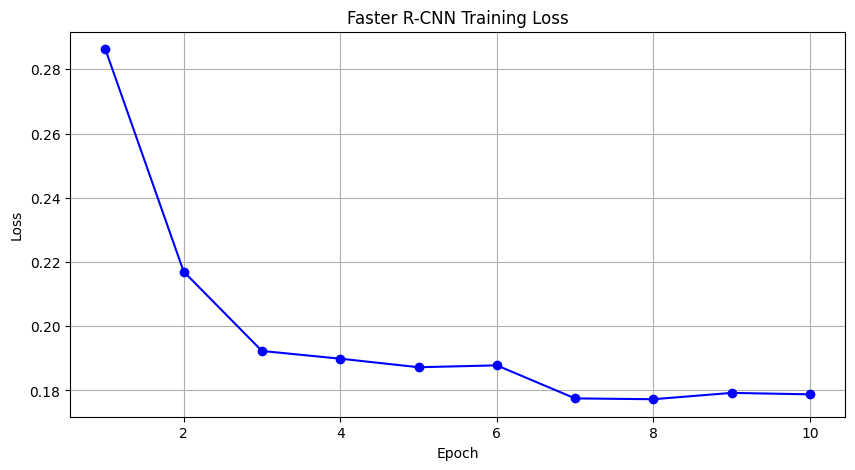

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Faster R-CNN Training Loss')
plt.grid(True)
plt.show()

In [ ]:
# Save model
MODEL_SAVE_PATH = os.path.join(BASE_PATH, "fasterrcnn_liam.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: /content/drive/MyDrive/ARI3129_CV_Project/fasterrcnn_liam.pth


## 7. Evaluation

In [ ]:
from torchvision.ops import box_iou
import numpy as np
from tqdm import tqdm
import torch

def calculate_map(model, data_loader, device, iou_threshold=0.5):

    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                all_predictions.append({
                    "boxes": output["boxes"].detach().cpu(),
                    "labels": output["labels"].detach().cpu(),
                    "scores": output["scores"].detach().cpu(),
                })
                all_targets.append({
                    "boxes": target["boxes"].detach().cpu(),
                    "labels": target["labels"].detach().cpu(),
                })

    num_classes = len(coco_data["categories"]) + 1  # + background at 0
    aps = []
    valid_class_ids = []  # classes with GT present

    for cls in range(1, num_classes):  # Skip background (0)
        cls_preds = []
        cls_targets = []

        total_gt_cls = 0
        for pred, target in zip(all_predictions, all_targets):
            # preds for this class
            pmask = pred["labels"] == cls
            cls_preds.append({
                "boxes": pred["boxes"][pmask],
                "scores": pred["scores"][pmask],
            })

            # gts for this class
            tmask = target["labels"] == cls
            gt_boxes_cls = target["boxes"][tmask]
            cls_targets.append({"boxes": gt_boxes_cls})
            total_gt_cls += gt_boxes_cls.shape[0]

        # If the class never appears in GT, skip it from the mean (prevents fake penalties)
        if total_gt_cls == 0:
            aps.append(0.0)  # still return aligned list for printing
            continue

        ap = calculate_ap_single_class(cls_preds, cls_targets, iou_threshold)
        aps.append(ap)
        valid_class_ids.append(cls)

    # Mean over only classes with GT
    valid_aps = [aps[c - 1] for c in valid_class_ids]  # aps index is cls-1
    mAP = float(np.mean(valid_aps)) if len(valid_aps) > 0 else 0.0

    return mAP, aps


def calculate_ap_single_class(predictions, targets, iou_threshold=0.5):

    all_scores = []
    all_matches = []
    total_gt = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred["boxes"]
        pred_scores = pred["scores"]
        gt_boxes = target["boxes"]

        total_gt += gt_boxes.shape[0]

        # No predictions: nothing to add
        if pred_boxes.shape[0] == 0:
            continue

        # Sort predictions by score DESC before matching
        order = torch.argsort(pred_scores, descending=True)
        pred_boxes = pred_boxes[order]
        pred_scores = pred_scores[order]

        # No GT: all predictions are false positives
        if gt_boxes.shape[0] == 0:
            for s in pred_scores:
                all_scores.append(float(s))
                all_matches.append(0)
            continue

        # IoUs between sorted preds and GTs
        ious = box_iou(pred_boxes, gt_boxes)

        gt_matched = set()
        for i in range(pred_boxes.shape[0]):
            all_scores.append(float(pred_scores[i]))

            max_iou, max_j = ious[i].max(0)
            j = int(max_j.item())

            if float(max_iou) >= iou_threshold and j not in gt_matched:
                all_matches.append(1)  # TP
                gt_matched.add(j)
            else:
                all_matches.append(0)  # FP

    if total_gt == 0 or len(all_scores) == 0:
        return 0.0

    # Sort all detections globally by score DESC
    sorted_idx = np.argsort(-np.array(all_scores))
    matches = np.array(all_matches)[sorted_idx]

    tp = np.cumsum(matches)
    fp = np.cumsum(1 - matches)

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (total_gt + 1e-12)

    # 11-point interpolation AP
    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        mask = recall >= t
        ap += (precision[mask].max() if mask.any() else 0.0) / 11.0

    return float(ap)

print("Evaluation functions defined!")

Evaluation functions defined!


In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
mAP, class_aps = calculate_map(model, test_loader, device, iou_threshold=0.5)

print("\n" + "=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"\nmAP@50 (mean over classes with GT): {mAP:.4f}")

print("\nPer-class AP@50:")
for cls_id, cat in enumerate(coco_data["categories"], start=1):  # cls_id starts at 1
    ap = class_aps[cls_id - 1]
    print(f"  {cat['name']}: {ap:.4f}")

Evaluating on test set...


Evaluating: 100%|██████████| 19/19 [00:35<00:00,  1.85s/it]


TEST SET RESULTS

mAP@50 (mean over classes with GT): 0.3093

Per-class AP@50:
  Stop: 0.4449
  No_Entry: 0.4922
  Pedestrian_Crossing: 0.5791
  Roundabout_Ahead: 0.3068
  No_Through_Road: 0.0331
  Blind_Spot_Mirror: 0.0000


## 8. Visualize Predictions

In [ ]:
# Category names for visualization
CATEGORIES = ['__background__'] + [cat['name'] for cat in coco_data['categories']]
COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']

def visualize_predictions(model, dataset, device, num_images=5, score_threshold=0.5):
    model.eval()

    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    for idx in indices:
        img, target = dataset[idx]

        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img_np = img.permute(1, 2, 0).numpy()

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Ground truth
        axes[0].imshow(img_np)
        axes[0].set_title('Ground Truth')
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='green', facecolor='none')
            axes[0].add_patch(rect)
            axes[0].text(x1, y1-5, CATEGORIES[label], color='white', fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.8))
        axes[0].axis('off')

        # Predictions
        axes[1].imshow(img_np)
        axes[1].set_title(f'Predictions (threshold={score_threshold})')

        pred_boxes = prediction['boxes'].cpu().numpy()
        pred_labels = prediction['labels'].cpu().numpy()
        pred_scores = prediction['scores'].cpu().numpy()

        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score >= score_threshold:
                x1, y1, x2, y2 = box
                color = COLORS[label % len(COLORS)]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=2, edgecolor=color, facecolor='none')
                axes[1].add_patch(rect)
                axes[1].text(x1, y1-5, f'{CATEGORIES[label]}: {score:.2f}',
                            color='white', fontsize=10,
                            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

print("Visualizing predictions on test set...")
visualize_predictions(model, test_dataset, device, num_images=5)

Output hidden; open in https://colab.research.google.com to view.

## 9. Summary & Results

In [ ]:
# Final summary
print("="*60)
print("FASTER R-CNN TRAFFIC SIGN DETECTION - SUMMARY")
print("="*60)
print(f"\nStudent: Liam")
print(f"Architecture: Faster R-CNN (ResNet50-FPN backbone)")
print(f"\nDataset:")
print(f"  Total images: {len(full_dataset)}")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")
print(f"\nTraining:")
print(f"  Epochs: {num_epochs}")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"\nTest Results:")
print(f"  mAP@50: {mAP:.4f}")
print(f"\nPer-class AP@50:")
for cat, ap in zip(coco_data['categories'], class_aps):
    print(f"  {cat['name']}: {ap:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*60)

FASTER R-CNN TRAFFIC SIGN DETECTION - SUMMARY

Student: Liam
Architecture: Faster R-CNN (ResNet50-FPN backbone)

Dataset:
  Total images: 484
  Train: 338
  Val: 73
  Test: 73

Training:
  Epochs: 10
  Final training loss: 0.1788

Test Results:
  mAP@50: 0.3093

Per-class AP@50:
  Stop: 0.4449
  No_Entry: 0.4922
  Pedestrian_Crossing: 0.5791
  Roundabout_Ahead: 0.3068
  No_Through_Road: 0.0331
  Blind_Spot_Mirror: 0.0000

Model saved to: /content/drive/MyDrive/ARI3129_CV_Project/fasterrcnn_liam.pth


In [ ]:
# Save results for comparison notebook
results = {
    'student': 'Liam',
    'architecture': 'Faster R-CNN (ResNet50-FPN)',
    'num_epochs': num_epochs,
    'train_losses': train_losses,
    'mAP50': mAP,
    'class_aps': {cat['name']: ap for cat, ap in zip(coco_data['categories'], class_aps)},
    'dataset_size': {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    }
}

results_path = os.path.join(BASE_PATH, "results_fasterrcnn_liam.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

Results saved to: /content/drive/MyDrive/ARI3129_CV_Project/results_fasterrcnn_liam.json
